#Quantum Assisted Gaussian Process (QGP) Simulations

This work book endeavours to simular Quantum Assisted Gaussian Processes (http://arxiv.org/abs/1512.03929). The code simulates the variance induced by the quantum system when using naturally sparse kernels.


In [15]:
import sys
import os
import numpy as np
%pylab inline
import matplotlib.pyplot as plt
import pyGPs

Populating the interactive namespace from numpy and matplotlib


## Kernels

We will use three kernels which lead to sparse covariance matrices. The first is from [MacKay](http://www.inference.eng.cam.ac.uk/mackay/gp.pdf):

$k(x,x')= 1 - |x-'x|/d,$ if $|x-'x|<d$

$k(x,x')= 0,$ otherwise

The second is from [Storkey](https://www.researchgate.net/profile/Amos_Storkey/publication/3835514_Truncated_covariance_matrices_and_Toeplitz_methods_in_Gaussian_processes/links/02bfe5120657a2b20f000000.pdf):

$k(x,x')= 1 + cos(|x-'x|/d),$ if $|x-'x|/d<\pi$

$k(x,x')= 0,$ otherwise

Finally, the third is from [Melkumyan](https://www.aaai.org/ocs/index.php/IJCAI/IJCAI-09/paper/viewFile/630/840):

$k(x,x')= \frac{1 - cos(2\pi \frac{|x-'x|}{d})}{3}(1 - \frac{|x-'x|}{d}) + \frac{1}{2\pi}sin(2\pi \frac{|x-'x|}{d}),$ if $|x-'x|<d$

$k(x,x')= 0,$ otherwise

The latter two kernels have very similar properties to the gaussian kernel (also known as the square exponential or rbf kernel).

Each of these kernels may be multiplied by a constant $\sigma^2$ which can be optimised during training. We also note that adding i.i.d. noise does not effect the sparsity. This noise $\sigma_n^2$ will also be optimised.

 /Library/Python/2.7/site-packages/IPython/kernel/__main__.py:186: RuntimeWarning:covariance is not positive-semidefinite.
 /Library/Python/2.7/site-packages/IPython/kernel/__main__.py:188: RuntimeWarning:covariance is not positive-semidefinite.


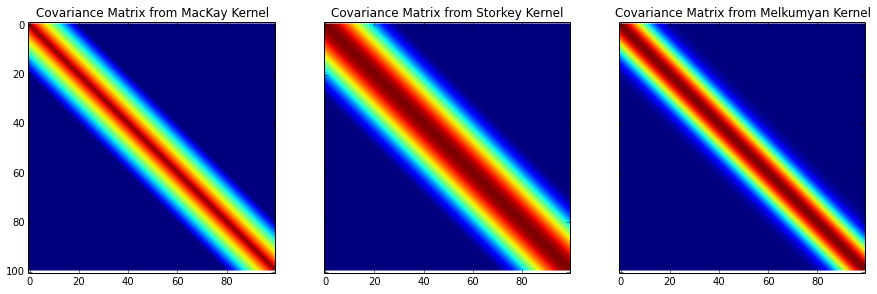

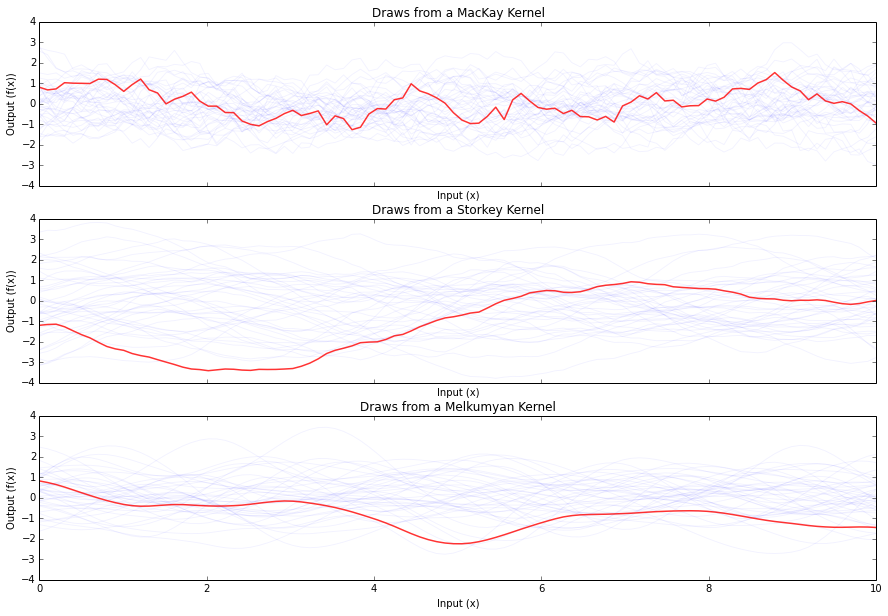

In [120]:
# Define the kernel functions

import scipy.spatial.distance as spdist

class kernel_mackay(pyGPs.Core.cov.Kernel):
    '''
    MacKay kernel with isotropic distance measure. hyp = [log_ell, log_sigma]
    :param log_ell: characteristic length scale.
    :param log_sigma: signal deviation.
    '''
    def __init__(self, log_ell=0., log_sigma=0.):
        self.hyp = [log_ell, log_sigma]

    def getCovMatrix(self,x=None,z=None,mode=None):
        #self.checkInputGetCovMatrix(x,z,mode)
        ell = np.exp(self.hyp[0])*2         # characteristic length scale
        sf2 = np.exp(2.*self.hyp[1])      # signal variance
        if mode == 'self_test':           # self covariances for the test cases
            nn,D = z.shape
            A = np.zeros((nn,1))
        elif mode == 'train':             # compute covariance matix for training set
            A = spdist.cdist((x/ell),(x/ell),'euclidean')
        elif mode == 'cross':             # compute covariance between data sets x and z
            A = spdist.cdist((x/ell),(z/ell),'euclidean')
        A[A>1] = 1.
        A = sf2 *(1. - A)
        return A


    def getDerMatrix(self,x=None,z=None,mode=None,der=None):
        #self.checkInputGetDerMatrix(x,z,mode,der)
        ell = np.exp(self.hyp[0])*2         # characteristic length scale
        sf2 = np.exp(2.*self.hyp[1])      # signal variance
        if mode == 'self_test':           # self covariances for the test cases
            nn,D = z.shape
            A = np.zeros((nn,1))
        elif mode == 'train':             # compute covariance matix for dataset x
            A = spdist.cdist((x/ell),(x/ell),'euclidean')
        elif mode == 'cross':             # compute covariance between data sets x and z
            A = spdist.cdist((x/ell),(z/ell),'euclidean')
        
        if der == 0:    # compute derivative matrix wrt 1st parameter
            A[A>1] = 0.
            A = sf2 * A / ell
        elif der == 1:  # compute derivative matrix wrt 2nd parameter
            A[A>1] = 1.
            A = 2. * sf2 *(1. - A)
        else:
            raise Exception("Calling for a derivative in MacKay kernel that does not exist")
        return A

class kernel_storkey(pyGPs.Core.cov.Kernel):
    '''
    Storkey kernel with isotropic distance measure. hyp = [log_ell, log_sigma]
    :param log_ell: characteristic length scale.
    :param log_sigma: signal deviation.
    '''
    def __init__(self, log_ell=0., log_sigma=0.):
        self.hyp = [log_ell, log_sigma]

    def getCovMatrix(self,x=None,z=None,mode=None):
        #self.checkInputGetCovMatrix(x,z,mode)
        ell = np.exp(self.hyp[0])         # characteristic length scale
        sf2 = np.exp(2.*self.hyp[1])      # signal variance
        if mode == 'self_test':           # self covariances for the test cases
            nn,D = z.shape
            A = np.zeros((nn,1))
        elif mode == 'train':             # compute covariance matix for training set
            A = spdist.cdist((x/ell),(x/ell),'euclidean')
        elif mode == 'cross':             # compute covariance between data sets x and z
            A = spdist.cdist((x/ell),(z/ell),'euclidean')
        A[A>np.pi] = np.pi
        A = sf2 *(1. + np.cos(A))
        return A


    def getDerMatrix(self,x=None,z=None,mode=None,der=None):
        #self.checkInputGetDerMatrix(x,z,mode,der)
        ell = np.exp(self.hyp[0])         # characteristic length scale
        sf2 = np.exp(2.*self.hyp[1])      # signal variance
        if mode == 'self_test':           # self covariances for the test cases
            nn,D = z.shape
            A = np.zeros((nn,1))
        elif mode == 'train':             # compute covariance matix for dataset x
            A = spdist.cdist((x/ell),(x/ell),'euclidean')
        elif mode == 'cross':             # compute covariance between data sets x and z
            A = spdist.cdist((x/ell),(z/ell),'euclidean')
        
        if der == 0:    # compute derivative matrix wrt 1st parameter
            A[A>np.pi] = 0.
            A = sf2 * A*sin(A)/ell
        elif der == 1:  # compute derivative matrix wrt 2nd parameter
            A[A>np.pi] = np.pi
            A = 2. * sf2 *(1. + np.cos(A))
        else:
            raise Exception("Calling for a derivative in Storkey kernel that does not exist")
        return A
    
class kernel_melkumyan(pyGPs.Core.cov.Kernel):
    '''
    Melkumyan kernel with isotropic distance measure. hyp = [log_ell, log_sigma]
    :param log_ell: characteristic length scale.
    :param log_sigma: signal deviation.
    '''
    def __init__(self, log_ell=0., log_sigma=0.):
        self.hyp = [log_ell, log_sigma]

    def getCovMatrix(self,x=None,z=None,mode=None):
        #self.checkInputGetCovMatrix(x,z,mode)
        ell = np.exp(self.hyp[0])*3         # characteristic length scale
        sf2 = np.exp(2.*self.hyp[1])      # signal variance
        if mode == 'self_test':           # self covariances for the test cases
            nn,D = z.shape
            A = np.zeros((nn,1))
        elif mode == 'train':             # compute covariance matix for training set
            A = spdist.cdist((x/ell),(x/ell),'euclidean')
        elif mode == 'cross':             # compute covariance between data sets x and z
            A = spdist.cdist((x/ell),(z/ell),'euclidean')
        idx = np.where(A>=1.)
        A = sf2 *(((2 + np.cos(2*np.pi*A))*(1 - A)/3) + np.sin(2*np.pi*A)/(2*np.pi))
        A[idx] = 0.
        return A


    def getDerMatrix(self,x=None,z=None,mode=None,der=None):
        #self.checkInputGetDerMatrix(x,z,mode,der)
        ell = np.exp(self.hyp[0])         # characteristic length scale
        sf2 = np.exp(2.*self.hyp[1])      # signal variance
        if mode == 'self_test':           # self covariances for the test cases
            nn,D = z.shape
            A = np.zeros((nn,1))
        elif mode == 'train':             # compute covariance matix for dataset x
            A = spdist.cdist((x/ell),(x/ell),'euclidean')
        elif mode == 'cross':             # compute covariance between data sets x and z
            A = spdist.cdist((x/ell),(z/ell),'euclidean')
        
        if der == 0:    # compute derivative matrix wrt 1st parameter
            idx = np.where(A>=1.)
             #-(4 d sin((pi d)/x) (pi (d-x) cos((pi d)/x)-x sin((pi d)/x)))/(3 x^3)
            A = sf2 * (-1) * (4*(A*ell)*sin(np.pi*A)*(np.pi*ell*(A-1)*cos(np.pi*A)-ell*sin(np.pi*A)))/(3*ell**3)
            A[idx] = 0.
        elif der == 1:  # compute derivative matrix wrt 2nd parameter
            idx = np.where(A>=1.)
            A = 2 * sf2 *(((2 + np.cos(2*np.pi*A))*(1 - A)/3) + np.sin(2*np.pi*A)/(2*np.pi))
            A[idx] = 0.
        else:
            raise Exception("Calling for a derivative in Melkumyan kernel that does not exist")
        return A
    
# Plot the kernels so we can see what we are working with

X = np.linspace(0, 10, 100).reshape(-1,1)

K_mackay = kernel_mackay()
K_storkey = kernel_storkey()
K_melkumyan = kernel_melkumyan()

K1 = K_mackay.getCovMatrix(X, mode='train')
K2 = K_storkey.getCovMatrix(X, mode='train')
K3 = K_melkumyan.getCovMatrix(X, mode='train')

f, (axa, axb, axc) = plt.subplots(1,3, sharex=True, sharey=True, figsize=[15,4.5])

axa.imshow(K1)
axa.set_title('Covariance Matrix from MacKay Kernel')

axb.imshow(K2)
axb.set_title('Covariance Matrix from Storkey Kernel')

axc.imshow(K3)
axc.set_title('Covariance Matrix from Melkumyan Kernel')

# Plot some draws from their function spaces

f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True, figsize=[15,10])

for r in range(40):
    f = np.random.multivariate_normal(np.zeros(100), K1)
    ax1.plot(X, f, 'b', linewidth=1, label='$f(t)$' if r==0 else None, alpha=0.05)
f = np.random.multivariate_normal(np.zeros(100), K1)
ax1.plot(X, f, 'r', linewidth=1.5, alpha=0.8)
ax1.set_title('Draws from a MacKay Kernel')
ax1.set_xlabel('Input (x)')
ax1.set_ylabel('Output (f(x))')
for r in range(40):
    f = np.random.multivariate_normal(np.zeros(100), K2)
    ax2.plot(X, f, 'b', linewidth=1, label='$f(t)$' if r==0 else None, alpha=0.05)
f = np.random.multivariate_normal(np.zeros(100), K2)
ax2.plot(X, f, 'r', linewidth=1.5, alpha=0.8)
ax2.set_title('Draws from a Storkey Kernel')
ax2.set_xlabel('Input (x)')
ax2.set_ylabel('Output (f(x))')
for r in range(40):
    f = np.random.multivariate_normal(np.zeros(100), K3)
    ax3.plot(X, f, 'b', linewidth=1, label='$f(t)$' if r==0 else None, alpha=0.05)
f = np.random.multivariate_normal(np.zeros(100), K3)
ax3.plot(X, f, 'r', linewidth=1.5, alpha=0.8)
ax3.set_title('Draws from a Melkumyan Kernel')
ax3.set_xlabel('Input (x)')
ax3.set_ylabel('Output (f(x))')

## Datasets (Large Scale)

We will check out three datasets where we might expect GPs using the above functions to model the data reasonably well.

### Property Dataset
### Airplane Dataset
### Land Altitude Dataset

While it is not feasible to compute the exact Gaussian processon these datasets, we can measure the level of sparsity in the covariance matrices. Note that when we refer to sparse matrices in this context we are talking about the fraaction of elements which are equal to zero as opposed to the more common low rank meaning in the Gaussian process community.

In [ ]:
# Set up

for i in xrange(3):
    # Load in Dataset

    # For compute the level of sparsity 

    # Print output
    print '...'
    

## Datasets (Small)

Now we will use small datasets (~10^4 observations) with which we can actually compute the exact Gaussian process and simulate the variance intoduced by the quantum computation. While these datasets are generally quite small, hopefully they will give us an indication of usefulness of QGPs.

### Housing Dataset

## QGP Simulation and Analytic Performance Bounds

In the code below we compute the exact GP, the analytic bound we derived for the QGP and a simulation which draws from the Bernoulli distibution to simulate the measurements of <M> in the QGP.

Housing Dataset Dim: 481 by 12
('Initial negative log marginal likelihood = ', 635.609)
('Time to optimize = ', 3.2631509999999935)
('Optimized mean = ', [])
('Optimized covariance = ', [0.12551429505310258, -0.16225226739576612, -0.5418704972169341])
('Optimized liklihood = ', [-2.3096007025998566])
('Final negative log marginal likelihood = ', 486.887)
('Kernel Sparsity = ', 0.058461538461538461)
('Observation Sparsity = ', 0.96257796257796258)
('Initial negative log marginal likelihood = ', 603.483)
('Time to optimize = ', 3.035948000000019)
('Optimized mean = ', [])
('Optimized covariance = ', [0.06709230529310507, -0.03450662567389444, -0.15948215861421783])
('Optimized liklihood = ', [-2.304203097111695])
('Final negative log marginal likelihood = ', 538.616)
('Kernel Sparsity = ', 0.23733887733887735)
('Observation Sparsity = ', 0.96257796257796258)
('Initial negative log marginal likelihood = ', 638.363)
('Time to optimize = ', 6.59862899999996)
('Optimized mean = ', [])
('Opti

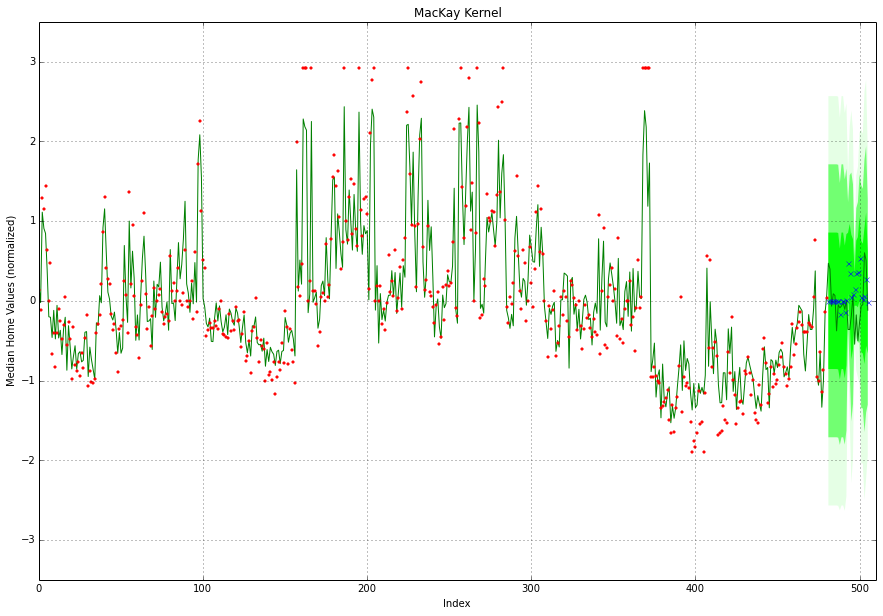

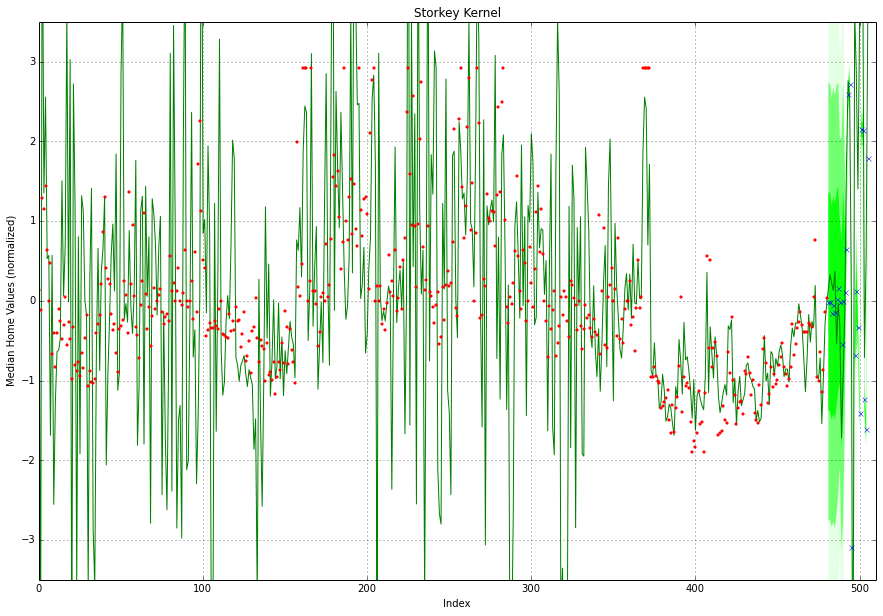

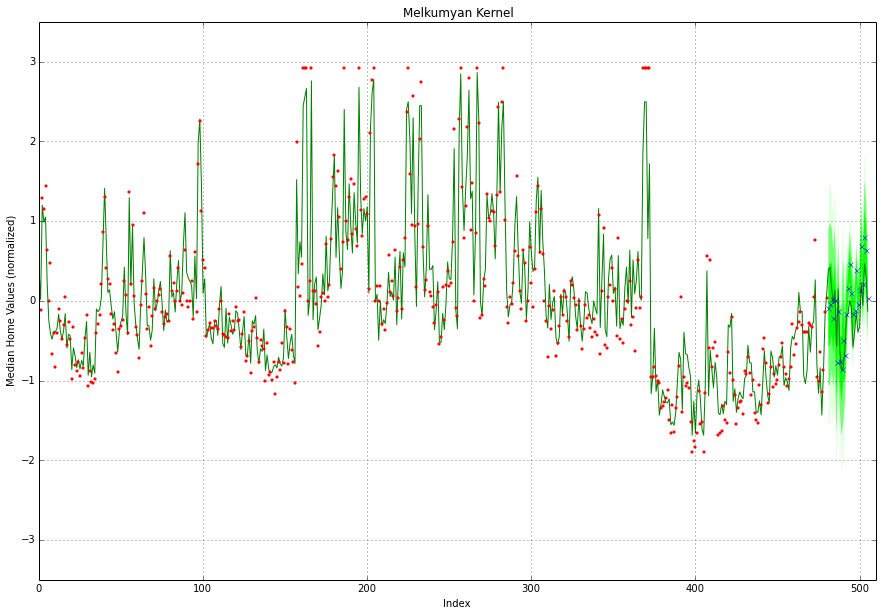

In [197]:
infile = 'datasets/small/housing.txt'
data = np.genfromtxt(infile)

DN, DD = data.shape
N = 25
# Get all data (exclude the 4th column which is binary) except the last 50 points for training
x  = np.concatenate((data[:-N,:4],data[:-N,5:-1]),axis=1)
x = (x - np.mean(x,axis=0))/(np.std(x,axis=0)+1.e-16)
# The function we will perform regression on:  Median Value of owner occupied homes
y  = np.reshape(data[:-N,-1],(len(data[:-N,-1]),1))
my = np.mean(y)
sy = np.std(y)
y = (y-np.mean(y))/(np.std(y)+1.e-16)
y[np.abs(y)<0.025] = 0
# Test on the last 50 points
xs  = np.concatenate((data[-N:,:4],data[-N:,5:-1]),axis=1)
xs = (xs - np.mean(xs,axis=0))/(np.std(xs,axis=0)+1.e-16)
ys = np.reshape(data[-N:,-1],(N,1))
ys = (ys-my)/(sy+1.e-16)
N,D = x.shape

print 'Housing Dataset Dim:', N, 'by', D

V = []
M = []
C = []
optHyp = []

for kernel_type in xrange(3):
    model = pyGPs.GPR()
    if kernel_type == 0:
        model.setPrior(kernel=kernel_mackay()+pyGPs.cov.Noise())
    elif kernel_type == 1:
        model.setPrior(kernel=kernel_storkey()+pyGPs.cov.Noise())
    else:
        model.setPrior(kernel=kernel_melkumyan()+pyGPs.cov.Noise())
    model.getPosterior(x, y)
    print('Initial negative log marginal likelihood = ', round(model.nlZ,3))

    # train and predict
    from time import clock
    t0 = clock()
    model.optimize(x,y)
    t1 = clock()
    ym, ys2, fm, fs2, lp = model.predict(xs)
    xa  = np.concatenate((data[:,:4],data[:,5:-1]),axis=1)
    xa = (xa - np.mean(xa,axis=0))/(np.std(xa,axis=0)+1.e-16)
    ya, ys2a, fma, fs2a, lpa = model.predict(xa)

    print('Time to optimize = ', t1-t0)
    print('Optimized mean = ', model.meanfunc.hyp)
    print('Optimized covariance = ', model.covfunc.hyp)
    print('Optimized liklihood = ', model.likfunc.hyp)
    print('Final negative log marginal likelihood = ', round(model.nlZ,3))
    print('Kernel Sparsity = ', np.mean(model.covfunc.getCovMatrix(x, xs, mode='cross')>0))
    print('Observation Sparsity = ', np.mean(y!=0))
    
    optHyp.append([model.meanfunc.hyp, model.covfunc.hyp, model.likfunc.hyp])
    
    cy = np.abs(y).max()**-1
    ck = np.abs(model.covfunc.getCovMatrix(x, xs, mode='cross')).max()**-1
    sy = np.sum(y!=0)
    sk = np.sum(model.covfunc.getCovMatrix(x, xs, mode='cross')!=0)
    sn = np.exp(model.covfunc.cov2.hyp[0]*2)
    
    C.append([np.sqrt(sy*sk)/(sn*ck*cy)]/np.mean(ys2))
    #V.append(ys2)
    #M.append(ym)
    
    #HousingPlotter(range(len(y)),y,range(len(ym)),ym,ys2,range(len(y),len(y)+len(ys)),ys)
    xm = np.array(list(range(len(y),len(y)+ym.shape[0])))
    ym = np.reshape(ym,(ym.shape[0],))
    zm = np.reshape(ys2,(ym.shape[0],))

    plt.figure(figsize=[15,10])

    plt.plot(ya,'g')
    plt.fill_between(xm, ym + 1.*np.sqrt(zm), ym - 1.*np.sqrt(zm), facecolor=[0.,1.0,0.0,0.9],linewidths=0.0)
    plt.fill_between(xm, ym + 2.*np.sqrt(zm), ym - 2.*np.sqrt(zm), facecolor=[0.,1.0,0.0,0.5],linewidths=0.0)
    plt.fill_between(xm, ym + 3.*np.sqrt(zm), ym - 3.*np.sqrt(zm), facecolor=[0.,1.0,0.0,0.1],linewidths=0.0)

    plt.plot(y,'r.',linewidth = 3.0, markersize = 5.0)
    plt.plot(xm,ym[-N:], 'bx', linewidth = 3.0, markersize = 5.0)
    plt.grid()
    if kernel_type == 0:
        plt.title('MacKay Kernel')
    elif kernel_type == 1:
        plt.title('Storkey Kernel')
    else:
        plt.title('Melkumyan Kernel')
    plt.xlabel('Index')
    plt.ylabel('Median Home Values (normalized)')
    plt.axis([0.,510.,-3.5,3.5])

In [246]:
DN, DD = data.shape
CA = []
steps = 50
runs = 30

for i in xrange(runs):
    p = np.random.permutation(DN)
    data = data[p,:]
    CC= []
    for N in [420-x*7 for x in range(steps)]:
        # Get all data (exclude the 4th column which is binary) except the last 50 points for training
        x  = np.concatenate((data[:-N,:4],data[:-N,5:-1]),axis=1)
        x = (x - np.mean(x,axis=0))/(np.std(x,axis=0)+1.e-16)
        # The function we will perform regression on:  Median Value of owner occupied homes
        y  = np.reshape(data[:-N,-1],(len(data[:-N,-1]),1))
        my = np.mean(y)
        sy = np.std(y)
        y = (y-np.mean(y))/(np.std(y)+1.e-16)
        y[np.abs(y)<0.025] = 0
        # Test on the last 50 points
        xs  = np.concatenate((data[-N:,:4],data[-N:,5:-1]),axis=1)
        xs = (xs - np.mean(xs,axis=0))/(np.std(xs,axis=0)+1.e-16)
        ys = np.reshape(data[-N:,-1],(N,1))
        ys = (ys-my)/(sy+1.e-16)
        N,D = x.shape

        print 'Housing Dataset Dim:', N, 'by', D

        V = []
        M = []
        C = []

        for kernel_type in xrange(3):
            model = pyGPs.GPR()
            if kernel_type == 0:
                model.setPrior(kernel=kernel_mackay()+pyGPs.cov.Noise())
            elif kernel_type == 1:
                model.setPrior(kernel=kernel_storkey()+pyGPs.cov.Noise())
            else:
                model.setPrior(kernel=kernel_melkumyan()+pyGPs.cov.Noise())
            model.getPosterior(x, y)

            model.meanfunc.hyp = optHyp[kernel_type][0]
            model.covfunc.hyp = optHyp[kernel_type][1]
            model.likfunc.hyp = optHyp[kernel_type][2]

            ym, ys2, fm, fs2, lp = model.predict(xs)
            xa  = np.concatenate((data[:,:4],data[:,5:-1]),axis=1)
            xa = (xa - np.mean(xa,axis=0))/(np.std(xa,axis=0)+1.e-16)
            ya, ys2a, fma, fs2a, lpa = model.predict(xa)

            cy = np.abs(y).max()**-1
            ck = np.abs(model.covfunc.getCovMatrix(x, xs, mode='cross')).max()**-1
            sy = np.sum(y!=0)
            sk = np.sum(model.covfunc.getCovMatrix(x, xs, mode='cross')!=0)/N
            sn = np.exp(model.covfunc.cov2.hyp[0]*2)

            C.append([np.sqrt(sy*sk)/(sn*ck*cy)]/np.mean(ys2))
        CC.append(C)
    CA.append(CC)

Housing Dataset Dim: 86 by 12
Housing Dataset Dim: 93 by 12
Housing Dataset Dim: 100 by 12
Housing Dataset Dim: 107 by 12
Housing Dataset Dim: 114 by 12
Housing Dataset Dim: 121 by 12
Housing Dataset Dim: 128 by 12
Housing Dataset Dim: 135 by 12
Housing Dataset Dim: 142 by 12
Housing Dataset Dim: 149 by 12
Housing Dataset Dim: 156 by 12
Housing Dataset Dim: 163 by 12
Housing Dataset Dim: 170 by 12
Housing Dataset Dim: 177 by 12
Housing Dataset Dim: 184 by 12
Housing Dataset Dim: 191 by 12
Housing Dataset Dim: 198 by 12
Housing Dataset Dim: 205 by 12
Housing Dataset Dim: 212 by 12
Housing Dataset Dim: 219 by 12
Housing Dataset Dim: 226 by 12
Housing Dataset Dim: 233 by 12
Housing Dataset Dim: 240 by 12
Housing Dataset Dim: 247 by 12
Housing Dataset Dim: 254 by 12
Housing Dataset Dim: 261 by 12
Housing Dataset Dim: 268 by 12
Housing Dataset Dim: 275 by 12
Housing Dataset Dim: 282 by 12
Housing Dataset Dim: 289 by 12
Housing Dataset Dim: 296 by 12
Housing Dataset Dim: 303 by 12
Housing Da

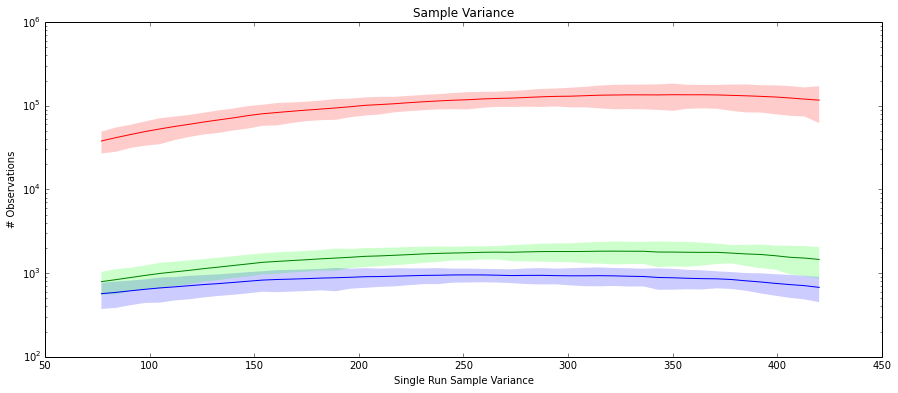

In [251]:
CA_ = np.array(CA)

CA__ = np.mean(CA_.reshape([runs, steps, 3]),0)
CA_s = np.std(CA_.reshape([runs, steps, 3]),0)

plt.figure(figsize=[15,6])
plt.title('Sample Variance')
plt.xlabel('Single Run Sample Variance')
plt.ylabel('# Observations')
plt.plot([420-x*7 for x in range(50)], CA__[::-1,0],'b')
plt.plot([420-x*7 for x in range(50)], CA__[::-1,1],'g')
plt.plot([420-x*7 for x in range(50)], CA__[::-1,2],'r')
plt.fill_between([420-x*7 for x in range(50)],CA__[::-1,0]+CA_s[::-1,0]*3,CA__[::-1,0]-CA_s[::-1,0]*3, facecolor= [0.,0.0,1.0,0.2],linewidths=0.0 )
plt.fill_between([420-x*7 for x in range(50)],CA__[::-1,1]+CA_s[::-1,1]*3,CA__[::-1,1]-CA_s[::-1,1]*3, facecolor= [0.,1.0,0.0,0.2],linewidths=0.0 )
plt.fill_between([420-x*7 for x in range(50)],CA__[::-1,2]+CA_s[::-1,2]*3,CA__[::-1,2]-CA_s[::-1,2]*3, facecolor= [1.,0.0,0.0,0.2],linewidths=0.0 )
plt.yscale('log')